<div class="alert-warning">
 <font size="+2"> <b> Single Cell Analysis Tutorial </b> </font>
</div>


This tutorial will cover the basic steps of single cell analysis. at the end of this tutorial you will be able to use `python` to

- Filter your data selecting specific criteria
- Preprocess your data for advanced analysis
- Identify potential cell types 
- Perform differential gene expression
- Visualize the basic differentiation dynamics of your data
- Merge datasets and do cross-data analysis

The present tutorial, like the rest of the course material, is available at our [open-source github repository](https://github.com/hds-sandbox/NGS_summer_course_Aarhus) and will be kept up-to-date as long as the course will be renewed.

A few introductory points to run this notebook:

* This tutorial is quite long and has a lot of text to read - the text is giving you as much important information as possible for you to understand the workflow. Try to go through at least part of this tutorial and do not rush to the end.
* To use this notebook, use the `NGS (python)` kernel that contains the packages. Choose it by selecting `Kernel -> Change Kernel` in the menu on top of the window.

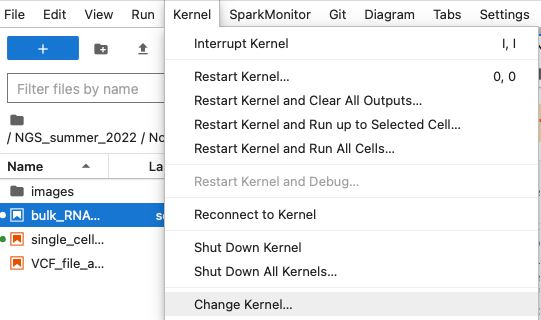

  
* In this notebook we will use primarily `python` commands. 
*   You can run the code in each cell by clicking on the run cell sign in the toolbar, or simply by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>. When the code is done running, a small green check sign will appear on the left side.
*   You need to run the cells in sequential order to execute the analysis. Please do not run a cell until the one above is done running, and do not skip any cells
*   The code goes along with textual descriptions to help you understand what happens. Please try not to focus on understanding the code itself in too much detail - but rather try to focus on the explanations and on the output of the commands 
*   You can create new code cells by pressing `+` in the Menu bar above or by pressing <kbd>B</kbd> after you select a cell. 

# Biological background

We will start by analyzing a dataset coming from various sections of human testicular tissue.
The testis is a complex organ composed of multiple cell types: germ cells at different stages of maturation and several somatic cell types supporting testicular structure and spermatogenesis (development of cells into spermatozoa); Sertoli cells, peritubular cells, Leydig cells, and other interstitial cells, as outlined in the figure below. Characterizing the various cell types is important to understand which genes and processes are relevant at different levels of maturations of cells into spermatozoa.

<figure>
<img src="images/celltypes.png" width="700" alt="Tubule scheme" class="center">
<figcaption> Figure: section of a tubule of the human testis. The human testis are surrounded by long tubules in which cells <br>start to develop, beginning from the walls of the tubules towards the center. At the center of the tubule, <br>spermatozoa will access to the epididymis to reach full maturation. </figcaption>
</figure>

After characterizing the spermatogenic process, we will perform comparative analysis of our dataset to testicular samples from men affected by azoospermia (reduced or absent froduction of spermatozoa). Infertility is a growing problem, especially in the Western world, where approximately 10–15% of couples are infertile. In about half of the infertile couples, the cause involves a male-factor ([Agarwal et al. 2015](https://rbej.biomedcentral.com/articles/10.1186/s12958-015-0032-1); [Barratt et al. 2017](https://pubmed.ncbi.nlm.nih.gov/28981651/)). One of the most severe forms of male infertility is azoospermia (from greek *azo*, *without life*) where no spermatozoa can be detected in the ejaculate, which renders biological fatherhood difficult. Azoospermia is found in approximately 10–15% of infertile men ([Jarow et al. 1989](https://pubmed.ncbi.nlm.nih.gov/2499695/); [Olesen et al. 2017](https://pubmed.ncbi.nlm.nih.gov/27793385/)) and the aetiology is thought to be primarily genetic.

Common to the various azoospermic conditions is the lack or distuption of gene expression patterns. It makes therefore sense to detect genes expressed more in the healthy dataset against the azoospermic one. We can also investigate gene enrichment databases to get a clearer picture of what the genes of interest are relevant to.

<figure>
<img src="images/azoospermia.jpeg" width="700" alt="Tubule Azoospermia" class="center">
<figcaption> Figure: Examples of testicular histology and the composition of testicular cell types that can be observed among men with various types of azoospermia. Degenerated ghost tubules (#) are tubules where an abnormally large central channel is present, but no cells are developing from the walls of the tubule. Other tubules show Sertoli-cell-only (SCO) pattern (*) and large clusters of Leydig cells, meaning they only have nurse cells, but no developing germ cells. Tubules with germ cell neoplasia in situ (GCNIS) do not contain any normal germ cells (&). GCNIS cells are the precursor cells of testicular germ cell cancer and are found more frequently among men with azoospermia than among men with good semen quality. From <a href="https://pubmed.ncbi.nlm.nih.gov/31950241/">Soraggi et al 2020</a>.</figcaption>
</figure>



# UMI-based single cell data from microdroplets



The dataset we are using in this tutorial is based on a microdroplet-based method from 10X chromium. From today's lecture we remember that a microdroplet single cell sequencing protocol works as follow:

- each cell is isolated together with a barcode bead in a gel/oil droplet

<figure>
<img src="images/droplet.gif" width="700" alt="Annotated Data">
<figcaption> Figure:  Isolation of cells and beads into microdroplets.</figcaption>
    </figure>

- each transcript in the cell is captured via the bead and assigned a cell barcode and a transcript unique molecular identifier (UMI)
- 3' reverse transcription of mRNA into cDNA is then performed in preparation to the PCR amplification
- the cDNA is amplified through PCR cycles
<figure>
<img src="images/10X.png" width="700" alt="Annotated Data">
<figcaption> Figure:  steps for the microdroplet-based single cell RNA sequencing after isolation.</figcaption>
    </figure>

## The raw data in practice

Let's look at a specific read and its UMI and cell barcode. The data is organized in paired-end reads (written on `fastq` files), where the first `fastq` file contains reads in the following format 

```
@SRR8363305.1 1 length=26
NTGAAGTGTTAAGACAAGCGTGAACT
+SRR8363305.1 1 length=26
#AAFFJJJJJJJJJJJJJJJJFJJJJ
```

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell barcode, while the last 10 characters `AGCGTGAACT` are the transcript UMI tag. The last line represents the quality scores of the 26 characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the following
```
@SRR8363305.1 1 length=98
NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGACCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCNTGTATGAGAT
+SRR8363305.1 1 length=98
#A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--<JFFF-7--7<<-F77---FF---7-7A-777777A-<-7---#-#A-7-7--7--
```
The 98nt-long string of characters in the second line is a partial sequence of the cDNA transcript. Specifically, the 10X chromium protocol used for sequencing the data is biased towards the 3' end, because the sequencing happens from the 3' to the 5' end of the transcripts. The last line contains the corresponding quality scores.

## Alignment and expression matrix

Once the data is sequenced, it is possible to align the reads to the transcriptome. This is done with tools that are sensible to the presence of spliced transcripts. We will skip the alignment step because it is quite trivial (it requires a [pipeline implemented by 10X](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) if you are using 10X data, otherwise you can use one of the available pipelines [available on NextFlow](https://nf-co.re/scrnaseq)), and because it would require too much time and memory for the scope of a one-day tutorial. Instead, we start from the transcript count matrix that results as the output from the transcriptome alignment.

# Data analysis

**Prepare packages and data necessary to run this python notebook.**
We will use *scanpy* as the main analysis tool for the analysis. Scanpy has a comprehensive [manual webpage](https://scanpy.readthedocs.io/en/stable/) that includes many different tutorials you can use for further practicing. Scanpy is used in the discussion paper and the tutorial paper of this course. 
An alternative and well-established tool for R users is [Seurat](https://satijalab.org/seurat/). However, scanpy is mainatined and updated by a wider community with many of the latest developed tools.

*Note:* it can take few minutes to get all the package loaded. Do not mind red-coloured warnings.

In [ ]:
import scanpy as sc
import bbknn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
import gc
import diffxpy.api as dxpy
import plotly.express as px

Some of the commands used in the course are functions we implement to simplify reading the code of this course. Mostly, those are commands requiring lines of code that would not add anything to your learning curve (management of plots, trivial calculations, few management of the notebook layout). However, you are free to look at the code into the file `Scripts/pythonScripts.py` and to reuse our code in your own work (citing our course).

In [ ]:
%run ../Scripts/pythonScripts.py

Check if the data folder is there

In [1]:
%%bash
sh ../Scripts/dataDownloadScript.sh

Datasets folder already exists, no need to download it


**Load the dataset.**

There are many different possible formats the data can be loaded from. Each format has a dedicated reading command in scanpy, for example `read_h5ad`, `read_10X`, `read_csv`,.... In our case, we have a file already in `h5ad` format. This format is very convenient to store data with large matrices and their annotations, and is often used to store the scRNAseq expression data after alignment and demultiplexing.

In [ ]:
adata = sc.read_h5ad('../Data/scrna_data/rawDataScanpy.h5ad')

The data is opened and an `Annotated data` object is created. This object contains:


*   The data matrix `adata.X` of size $N\_cells \times N\_genes$. The cells are called observations (obs) and the genes variables (var).
*   Vectors of cells-related variables in the dataframe `adata.obs`
* Vectors of genes-related variables in the dataframe `adata.var`
* Matrices of size $N\_cells \times N\_genes$ in `adata.layers`
* Matrices where each line is cell-related in `adata.obsm`
* Matrices where each line is gene-related in `adata.varm`
* Anything else that must be saved is in `adata.uns`


<fifgure>
<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg" width="500" alt="Annotated Data">
<figcaption> Figure: Structure of an annotated data object. In green the stack of expression matrix it can contains, where `X` is the one currently used for analysis.</figcaption>
    </figure>

The data has 62751 cells and 33694 genes

In [ ]:
adata.shape

We calculate quality measures to fill the object `adata` with some information about cells and genes

In [ ]:
sc.preprocessing.calculate_qc_metrics(adata, inplace=True)

We can see that now `adata` contains many observations (`obs`) and variables (`var`). Those can be used for filtering and analysis purpose, as well as they might be needed by some scanpy tools

In [ ]:
adata

`adata.obs` is a dataframe, i.e. a table with indexes on the rows (cell barcodes) and column names (the observation types). One can select a specific observation type by indexing it in the table

In [ ]:
adata.obs.head()

In [ ]:
adata.obs['batch'] #sample label - the data contains 15 separate samples

`adata.var` works similarly, but now each row is referred to a gene

In [ ]:
adata.var.head()

In [ ]:
adata.var['n_cells_by_counts'] #nr of cells showing transcripts of a gene

## Preprocessing

We preprocess the dataset by filtering cells and genes according to various quality measures and removing doublets.  Note that we are working  with all the samples at once. It is more correct to filter one sample at a time, and then merge them together prior to normalization, but we are keeping the samples merged for simplicity, and because the various samples are technically quite homogeneous.

### Quality Filtering
Using the prefix `MT-` in the gene names we calculate the percentage of mithocondrial genes in each cell, and store this value as an observation in `adata.obs`. Cells with high MT percentage are often broken cells that spilled out mithocondrial content (in this case they will often have low gene and transcript counts), cells captured together with residuals of broken cells (more unlikely if a good job in the sequencing lab has been done) or empty droplets containing only ambient RNA.

In [ ]:
MT = ['MT-' in i for i in adata.var_names] #a vector with True and False to find MT genes
perc_mito = np.sum( adata[:,MT].X, 1 ).A1 / np.sum( adata.X, 1 ).A1
adata.obs['perc_mito'] = perc_mito.copy()

One can identify cells to be filtered out by looking at the relation between number of transcripts (horizontal axis) and number of genes per cell (vertical axis), coloured by percent of MT genes. We can see that high percentages of mitocondrial genes are present for cells that have less than 1000 detected genes (vertical axis).

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='perc_mito', 
              title='Transcript vs detected genes coloured by mitochondrial content')

We can zoom into the plot by selecting cells with less than 3000 genes

In [ ]:
sc.pl.scatter(adata[adata.obs['n_genes_by_counts']<3000], x='total_counts', y='n_genes_by_counts', color='perc_mito',
             title='Transcript vs detected genes coloured by mitochondrial content\nfor <3000 genes')

Another useful visualization is the distribution of each quality feature of the data. We look at the amount of transcripts per cell zooming into the interval (0,20000) transcripts to find a lower threshold. Usually, there is a peak with low quality cells on the left side of the histogram, or a descending tail. The threshold whould select such peak (or tail). In our case we can select 2000 as threshold.

In [ ]:
fig = px.histogram(adata[adata.obs['total_counts']<20000].obs, x='total_counts', nbins=100,
                  title='distribution of total transcripts per cell for <20000 transcripts')
fig.show()

For the upper threshold of the number of transcripts, we can choose 40000

In [ ]:
fig = px.histogram(adata.obs, x='total_counts', nbins=100, 
                   title='distribution of total transcripts per cell')
fig.show()

Regarding the number of detected genes, a lower threshold could be around 800 genes. An Upper threshold can be 8000 genes, to remove the tail on the right side of the histogram

In [ ]:
fig = px.histogram(adata.obs, x='n_genes_by_counts', nbins=100, title='distribution of detected genes per cell')
fig.show()

Cells with too much mitochondrial content might be broken cells spilling out MT content, or ambient noise captured into the droplet. Standard values of the threshold are between 5% and 20%. We select 20%.

In [ ]:
fig = px.histogram(adata.obs, x='perc_mito', nbins=100, title='distribution of mitochondrial content per cell')
fig.show()

Finally, we look at the percentage of transcripts expressing genes in each cell. We plot the genes showing the highest percentages in a barplot. We can see MALAT1 is expressed in up to 60% of the transcripts in some cells. This can be an indicator of cells with too low quality. Other genes that are highly expressed are of the mitocondrial type and will be filtered out already with the mitochondrial threshold. PRM1, PRM2, PTGDS are typical of spermatogonial processes, and we do not consider those as unusual

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_title('Top genes in terms of percentage of transcripts explained in each cell')
fig = sc.pl.highest_expr_genes(adata, n_top=20, ax=ax)

We save the percentages of transcripts expressing MALAT1 and select a threshold for this values. We choose 10% as threshold to cut out the upper tail.

In [ ]:
perc_malat = np.sum( adata[:,'MALAT1'].X, 1 ).A1 / np.sum( adata.X, 1 ).A1
adata.obs['perc_MALAT1'] = perc_malat.copy()

In [ ]:
fig = px.histogram(adata.obs, x='perc_MALAT1', nbins=100)
fig.show()

We use the following commands to implement some of the thresholds discussed in the plots above

In [ ]:
sc.preprocessing.filter_cells(adata, max_genes=8000)

In [ ]:
sc.preprocessing.filter_cells(adata, min_genes=800)

In [ ]:
sc.preprocessing.filter_cells(adata, max_counts=40000)

In [ ]:
adata = adata[adata.obs['perc_mito']<0.2].copy()

In [ ]:
adata = adata[adata.obs['perc_MALAT1']<0.1].copy()

It is good practice to also remove those genes found in too few cells (for example in 10 or less cells). Any cell type clustering five or less cells will be not detected in the data, but in any case it would be irrelevant to have such tiny clusters.

In [ ]:
sc.preprocessing.filter_genes(adata, min_cells=10)

In [ ]:
print('There are now', adata.shape[0], 'cells and', adata.shape[1],'genes after filtering')

### Doublets removal

Another important step consists in filtering out multiplets. We will use the package `scrublet` [(Wolock et al, 2019)](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(18)30474-5), that simulates doublets from the data and compare the simulations to the real data to find any doublet-like cells in it. 
<figure>
<img src="images/scrublet.jpg" width="700" alt="Scrublet">
<figcaption> Figure: schematics of the `scrublet algorithm`, from the related paper.</figcaption>
    </figure>


Multiplets are in the almost  totality of the cases doublets, because triplets and higher multiplets are extremely rare. We will thus talk only about doublets instead of multiplets. Read [this more technical blog post](https://liorpachter.wordpress.com/2019/02/07/sub-poisson-loading-for-single-cell-rna-seq/) for deeper explanations about this fact.

Below, we run `scrublet` on the data. The package is part of the `scanpy` tool and straightforward to use. As a required parameter, you have to insert the expect doublet rate. A rule of thumb is to choose 6% as a typical rate, because is the value in between the possible doublet rates depending on how many cells are loaded in a single cell experiment. Otherwise, you can have a look [at this table](https://kb.10xgenomics.com/hc/en-us/articles/360059124751-Why-is-the-multiplet-rate-different-for-the-Next-GEM-Single-Cell-3-LT-v3-1-assay-compared-to-other-single-cell-applications-) to see what is the expected doublet rate for different amounts of cells loaded in a single cell 10X experiment. In our case, each sample ranges somewhere between 3000 and 5000 cells, so one could use 3% as a possible guess.

<figure>
<img src="images/doublet_rates.png" width="700" alt="Doublets">
<figcaption> Figure: doublet rates for various setting in a single cell experiment with 10X technology.</figcaption>
    </figure>

In [ ]:
sc.external.pp.scrublet(adata, #dataset
                        expected_doublet_rate=0.06, #the chosen doublet rate as an estimate to start from
                        random_state=12345)

We gave 6% as expected doublet rate, but note how the algorithm estimated that the doublet rate is estimated to be actually 3%. Not far away from what one could guess using the doublet rates' table, meaning that, in this regard, the data has been produced pretty well. 

We now plot the doublet scores assigned to each cell by the algorithm. We can see that most cells have a low score (the score is a value between 0 and 1, where 1 is a theoretically perfect doublet). Datasets with many doublets show a more bimodal distribution (look for example at [this jupyter notebook](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) from the `scrublet` tutorial), while here we just have a light tail beyond 0.1. Therefore we will filter out the cells above this threshold

In [ ]:
fig = px.histogram(adata.obs, x='doublet_score', title='Distribution of doublet scores per cell')
fig.show()

In [ ]:
adata = adata[ adata.obs['doublet_score']<.1 ].copy()

### Data Normalization

Biologically similar cells are not necessarily **directly comparable** in a dataset because of different technical biases - amongst many the different percentage of captured transcripts (capture efficiency), the presence of technical replicates, the presence of noisy transcripts. The capture efficiency can be influenced by many factors, i.e. the different transcript tags leading to different capture efficiency, the type of protocol used in the laboratory, the amount of PCR performed on different transcripts. Biological biases might as well alter the transcript proportion in a cell, for example in case of different points in the cell cycles altering the expression of specific genes.

To avoid these differences, a **normalization** approach is needed. Normalization is one of the main topics of scRNAseq data preprocessing, and many advanced techniques take into account the statistical distribution of counts and the presence of technical/biological features of interest ([Lytal et al, 2020](https://www.frontiersin.org/articles/10.3389/fgene.2020.00041/full)).

The most standard approach is the **TMP (Transcript Per Million) normalization**. Here, the transcripts is each cell are rescaled by a factor such that the transcripts in each cell sum to the same value. After TPM rescaling, the data is usually logarithmized, so that a transcript $x$ becomes $log(x+1)$. Logarithmization is known to help reducing the technical bias induced by the amount of transcripts in each cell. Finally, the data is standardized with mean 0 and variance 1. This is necessary since the PCA assumes implicitly that datapoints are normally distributed.

As a rule of thumb, TPM works fine but might introduce biases in the data, mostly due to technical differences that are not always removed by normalization. It is possible to use more advanced methods for considering technical and biological covariates as part of a statistical model for the transcripts. One of the current state-of-the-art method is *scTransform* ([Hafemeister and Satija, 2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)). This is currently implemented in `R`.

### Effect of normalization on technical features

Before normalizing we look at the highest correlation between the PCA of the raw data and some technical features. The first component of the PCA has the highest $R^2$ when correlated with the total amount of transcripts. PC5 is mostly correlated with the amount of mitochondrial transcripts. This means that the two PC components mostly describe variations in the technical features and misses the description of biological variation. We will see after normalization that these correlations are reduced. Note that we are plotting the correlations for one specific sample, `Guo1`, but the concept holds for the remaining samples.

In [ ]:
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
dependentFeatures(adata=adata[adata.obs['batch']=='Guo1'], obs_subset=['total_counts','perc_mito'])

### <div class="alert-success"> <font size="+2"> <b> Optional task </b> </font> </div>
Try to look at other samples and see if there are some principal components highly dependent with technical features. You might also want to choose other technical features from the data.

The available samples are


In [ ]:
print( list(adata.obs['batch'].cat.categories) )

and the technical features

In [ ]:
print( list( adata.obs.columns ) )

In [ ]:
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
dependentFeatures(adata=adata[adata.obs['batch'] == ''], #sample name
                  obs_subset=['total_counts','perc_mito']) #technical features

<div class="alert-success"> <font size="+2"> <b> End of optional task </b> </font> </div>

Here we execute the normalization steps. We use the standard TPM normalization and evaluate the result looking at the data projections later on. We select also the most variable genes to avoid considering genes that have very constant expression across all the dataset, and are therefore not informative. The most variable genes are used to create the PCA projection of the data, and we can use them also in other parts of the analysis.

In [ ]:
# save raw data matrix
adata.layers['raw_counts'] = adata.X.copy()
# TPM normalization
sc.pp.normalize_per_cell(adata)
# matrix logarithmization
sc.pp.log1p(adata)
# most variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=15000)
#scale
sc.pp.scale(adata)
adata.layers['scaled_counts'] = adata.X.copy()

After normalization the linear correlations are visibly much reduced.

In [ ]:
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345, use_highly_variable=True)
dependentFeatures(adata=adata[adata.obs['batch']=='Guo1'], obs_subset=['total_counts','perc_mito'])

### Dimensionality reduction

With the term **dimensionality reduction**, we intend the projection of each data point (cell) $x=[x_1, x_2, \dots, x_{N_{cell}}]$ into a data point $y$ in  $D$ dimensions, so that $y=[y_1, y_2, \dots, y_D]$, where $D << N_{cell}$.

Dimensionality reduction is meaningful for single cell data analysis, since we know that the genes are expressed in modules of co-expression, meaning that the behaviour of many co-expressed genes can be compressed into the same dimension. 

Moreover, using computationally heavy algorithms on the reduced data will help speeding up calculations and reduce memory use, though using a reliable approximation of the full-dimension dataset. 

### PCA

PCA is one of the most used dimensionality reduction methods. It projects the data by identifying the axis of maximum variation. Since axis are orthogonal, PCA is best for data that has a linear behaviour. However, it has proved to be a reliable method for single cell data, especially to establish the PCA projection as the starting point for computational methods. We calculated the PCA already few lines above, when we checked the correlation with technical variables after normalization.

You can visualize the ratio of variances of each subsequent pair of principal components, where you can see which number of dimensions is best to consider for further applications. Low variance ratios illustrate that along their principal components only little information is represented, probably mostly backgound noise of the dataset. Here we can for example say that 15 dimensions mostly explain the meaningful biological variation in the data. We will use the option `n_pcs=15` in some of the functions of `scanpy` that are based on the PCA.

In [ ]:
sc.plotting.pca_variance_ratio(adata)

You can plot any dimensionality reduction and colour cells by elements of `adata.obs` or by gene expression. Below we plot the PCA coloured by different samples composing the dataset, the total number of transcripts and the expression of gene SYCP1. Note how the various samples overlap into the PCA plot. In some cases you can see that the PCA plot is composed of chunks separated by sample, but fortunately this is not our situation. 

In such case more advanced techniques for normalization are needed, so that the samples are taken into account. `Scanpy` has the function `sc.pp.combat` to normalize accounting samples, but there are many other possibilities such as the package `mnnCorrect`. 

In [ ]:
plt.rcParams['figure.figsize'] = (6,6) #reduce figure size
sc.pl.pca(adata, color=['batch','total_counts','SYCP1'])

### UMAP projection

UMAP [(McInnes et al, 2018)](https://joss.theoj.org/papers/10.21105/joss.00861) is another projection algorithm that finds the optimal formulation of the projection criteria according to some topological theory, aiming at preserving the structure of the high-dimensional graph describing the data. This projection technique has become [one of the most used and appreciated](https://www.nature.com/articles/s10038-020-00851-4), and is structured in a way that calculations are faster than in other algorithms, and scale less than exponentially with the number of dimensions. Explore [this "paper with code"](https://paperswithcode.com/method/parametric-umap) to learn about UMAP and its extension applied to neural networks. UMAP has also a [manual page](https://umap-learn.readthedocs.io/en/latest/) with other examples in `python`.

<img src="images/umap.png" width="700" alt="UMAP">

We calculate first the neighborhood of each cell (the distance between the most similar cells). We use the package `bbknn` to take samples into account and reduce any remaining difference between samples, even though we can see a good overlapping in the PCA plot. In case you haven't multiple samples, you can use the function `sc.pp.neighbors`. Note that we impose the use of 15 PCA components.

In [ ]:
bbknn.bbknn(adata, n_pcs=15)

We calculate and plot the UMAP projection. We calculate three components, so we can also produce a 3d plot

In [ ]:
sc.tools.umap(adata, random_state=54321, n_components=3)

The plot is made for different pairs of dimensions (1,2 - 1,3 - 2,3) and coloured by a single gene expressed in spermatids. You can observe how there are some smaller clusters separated from a main block of cells looking like a long "snake". Note also that clusters that seem close to each other, might actually end up being far away when rotating our point of view.

In [ ]:
sc.plotting.umap(adata, color=['TNP2'], components=['1,2','1,3','2,3'])

We can look better at the projection in 3D. Here the colour represents the total transcripts per cell. The main group of cells seems twisting at least twice without overlapping, but we do not see any branching. This might mean that there is only one differentiation path.

In [ ]:
X = adata.obsm['X_umap']
fig = px.scatter_3d(adata.obsm, x=X[:,0], y=X[:,1], z=X[:,2], color=adata.obs['total_counts'], opacity=.5)
fig.show()

We can also colour by a specific gene. Try any gene you want (inserted here instead of `TNP2`)

In [ ]:
X = adata.obsm['X_umap']
fig = px.scatter_3d(adata.obsm, x=X[:,0], y=X[:,1], z=X[:,2], color=np.ravel(adata[:,'TNP2'].X))
fig.show()

You can also use a standard plotting command to visualize the 3d plot, but it cannot be rotated interactively

In [ ]:
sc.plotting.umap(adata, color=['TNP2'], projection='3d', components=['1,2,3'] )

### <div class="alert-success"> <font size="+2"> <b> Exercise: tSNE projection </b> </font> </div>

PCA and UMAP are two of the many projection methods available at the moment. Before UMAP, a very popular method was (and still is) tSNE [van der Maaten and Hinton, 2008](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). tSNE tries to match the statistical distribution of the high-dimensional data and its projection. The statistical distribution modeling high-dimensional data is controlled by a parameter called *perplexity*, defining how far away cells are considered to be in the neighbourhood of a cell. The largest the perplexity, the farther away cells are going to be pulled close to each other in the tSNE projection. In general, tSNE is not very good at keeping the global behaviour of the data into account, while it often pulls cells together in separate chunks. 

Changing the perplexity can change a lot the output of tSNE, even though it has shown empirically being stable with values between 5 and 50.
Here you can experiment different values of the perplexity and plot tSNE. You will see how - for lower perplexities - tSNE cannot keep the dataset together as in the UMAP projection, dividing it instead into many chunks covering a large 2D space. The tSNE algorithm is actually quite slow, especially with increasing perplexity, so we will subsample the dataset to be only 5000 cells.

You can also change the method measuring distances between points. The standard distance is `euclidean`, and you can change this parameter with `cityblock`, `cosine`, `euclidean`, `l1`, `l2`, `manhattan`, `braycurtis`, `canberra`, `chebyshev`, `correlation`, `dice`, `hamming`, `jaccard`, `kulsinski`, `mahalanobis`, `minkowski`, `rogerstanimoto`, `russellrao`, `seuclidean`, `sokalmichener`, `sokalsneath`, `sqeuclidean`, `yule`. Some of those distances are well-known for people handy with data science or mathematics, others are more obscure.

When you find a plot you deem to be the nicest one, save it and upload it to [this google drive folder](https://drive.google.com/drive/folders/12bS612ad42GFqNEGBRtM4lZ-05-6NuRq?usp=sharing).

In [ ]:
YOUR_NAME = 'WRITE YOUR NAME HERE'
PERPLEXITY = 5
DISTANCE_METRIC = 'euclidean'

In [ ]:
adata_sub = sc.pp.subsample(adata, random_state=54321, n_obs=5000, copy=True)

In [ ]:
sc.tools.tsne(adata_sub, random_state=54321, perplexity=PERPLEXITY, metric=f'{DISTANCE_METRIC}')

In [ ]:
sc.plotting.tsne(adata_sub, color=['batch'], legend_loc=None, frameon=False, title=f'{YOUR_NAME}\nPerplexity={PERPLEXITY} Metrix={DISTANCE_METRIC}')

This saves the plot in the folder `figures`. You can download it from there (right click on the file and choose Download) and then upload it on [this google drive folder](https://drive.google.com/drive/folders/12bS612ad42GFqNEGBRtM4lZ-05-6NuRq?usp=sharing) if you wish.

In [ ]:
sc.plotting.tsne(adata_sub, color=['batch'], legend_loc=None, frameon=False, 
                 title=f'{YOUR_NAME}\nPerplexity={PERPLEXITY} Metric={DISTANCE_METRIC}', show=False,  
                 save=f'{YOUR_NAME}Perplexity={PERPLEXITY}Metric={DISTANCE_METRIC}.png')

## Clusters Identification

Cell types can be identified and then assigned to clusters calculated by one of the many available clustering techniques.
When identifying a cluster, we can assign that to a likely cell type by visualizing known markers on a projection plot, e.g. an UMAP plot. Similarly, one can score cells for a set of markers. Finally, if an atlas of cell types is available, one can use it for a supervised assignment of cell types ([see for example the `R` package `scmap`](https://github.com/hemberg-lab/scmap)) and [the `ingest` tool from `scanpy`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.ingest.html).

Be aware that clusters do not necessarily match perfectly cell types (especially if cells change in a continuous way, hard clusters are not the best solution, though an acceptable one). 



### Print markers' scores

The first step to identify various cell types is to print markers on the UMAP plot. We will print markers' scores, that is the average expression of a list of markers, subtracted of the average expression of some random genes. We provide a python dictionary including some cell types and a few of their marker genes.

A dictionary is a python object in which you can allocate different objects (matrices, vectors, lists, ...), each having an assigned name. Here, we have lists of marker genes, where each list is identified by the name of the corresponding cell type. To remember the different stages of spermatogenesis, a scheme is attached below, and you can read more about the spermatogenic process [at this page](https://embryology.ch/en/embryogenese/gametogenesis/spermatogenesis/developmental-stages-of-spermatogenesis.html?p=2#developmental-stages-of-spermatogenesis)

<img src="images/spermatogenesis.gif" width="500" alt="Spermatogenesis">

In [ ]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']
markers['Pericyte'] = ['MYL9']

We calculate the scores for the markers

In [ ]:
markers_scores, adata = marker_score(markers, adata)

Make a separate UMAP plot for every cell type. You should be able to see quite clearly some clusters where the marker's expressions are stronger. Sertoli cells are usually hard to identify - their markers are expressed also in other cell types, and often Sertoli cells are not captured due to their size. It seems that there aren't sertoli cells into our dataset.

In [ ]:
sc.plotting.umap(adata, color=markers_scores, components=['1,2'], ncols=2, vmax=5, s=30)

### Leiden clustering algorithm 

Scanpy contains the *leiden* algorithm [(Traag et al, 2019)](https://www.nature.com/articles/s41598-019-41695-z), making clusters whose points are well connected and at the same time mostly disconnected from other clusters. Other approaches, e.g. *k-means*, can be performed on the data or on its PCA/tSNE/UMAP projection. The leiden algorithm is however [considered to be one of the best techniques at the moment](https://theses.liacs.nl/pdf/2017-2018-QatoKristi.pdf) to find communities of similar datapoints, and we will therefore use that. Read more about the leiden algorithm [here](https://api.semanticscholar.org/CorpusID:54692004).

<figure>
<img src="images/leiden.png" width="500" alt="leiden">
<figcaption> Figure: refinement steps used by the `leiden algorithm` to find communities of well-connected points.</figcaption>
    </figure>

We calculate some clusterings at various resolution, and choose the one matching best the clusters we have visualized from the markers' score. The amount of clusters depend on the chosen resolution. Later in this tutorial, we will integrate this dataset with another one, showing how to cluster the new data using ours as a "reference" clustering. 

In [ ]:
#leiden clustering at various resolutions
sc.tools.leiden(adata, resolution=1, random_state=12345, key_added='leiden_R1')
sc.tools.leiden(adata, resolution=0.5, random_state=12345, key_added='leiden_R.5')
sc.tools.leiden(adata, resolution=0.25, random_state=12345, key_added='leiden_R.25')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

We can see that at resolution 1 we have many clusters, and their number decreases with decreasing resolution. It seems that 0.25 is the resolution best matching the clusters we desire to annotate.

In [ ]:
sc.plotting.umap(adata, color=['leiden_R1','leiden_R.5','leiden_R.25', 'leiden_R.1'], legend_loc='on data', ncols=2)

### Differential Gene expression

It is not always easy to assign clusters from marker scores.  For example, cluster 12 at resolution 0.25 is not immediately recognizable as pericyte cells. Sometimes it is good to double check which genes are most expressed in a cluster compared to all the others before assigning cell types. Here we look at the 50 most expressed genes in each cluster from the Leiden algorithm.

Differential gene expression is also the way of making a sound argument in a publication or report. Showing fancy UMAP plots coloured by gene expression is sadly not enough :) A standard way to do it, is to test if each gene has mean expression higher in a cluster than in all the others. Scanpy does that by using a t-test or the wilcoxon test. While the t-test is somewhat less powerful, the wilcoxon test is not best behaved with very sparse data, so we simply apply the default t-test to the dataset. Note that, for the standard t-test in scanpy, you need to use logarithmized data.

More advanced techniques that model the statistical properties of the data, such as its sparsity, are available for differential expression. See for example the package `MAST` ([Finak et al, 2015](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0844-5)) and the following review on differential expression methods: ([Squair et al, 2021](https://www.nature.com/articles/s41467-021-25960-2)).

In [ ]:
#Perform the test on logarithmized data
adata.X = adata.layers['raw_counts'] #raw data
sc.pp.normalize_total(adata) #TPM normalization
sc.pp.log1p(adata) #logarithm
sc.tl.rank_genes_groups(adata, groupby='leiden_R.25', n_genes=50) #Top 50 diff.expressed genes in each cluster
adata.X = adata.layers['scaled_counts'] #Set again the scaled data as standard data matrix

Organize result in a table. Each column has the cluster numbers with `_N`, `_P`, `_L` representing respectively the gene `N`ames, their `P`-values and the `L`og-fold change of each gene expression compared to the other clusters.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
X.head() #print only first five lines

We can look specifically at the genes for cluster 12. MYL9 is one of the first in the list and associated with pericyte cells, as well as MYL6 and PTMA. Note how the list shows some mitochondrial genes (starting with MT) - these might be coming from some transcripts pertaining ambient noise, but they are down in the lower positions in the list, meaning our initial filtering has reduced their effect on our analysis.

In [ ]:
X[ ['12_N'] ]

The table can also be exported into csv format in the folder `results_scrna`. It can be opened using `jupyterlab` as well `Excel` if you download it and set the comma character <kbd>,</kbd> as separator

In [ ]:
!mkdir -p results_scrna

In [ ]:
X.to_csv('./results_scrna/DiffExpression_NoAnnotation.csv', sep=',', index=None)

### Cluster assignment
Defining the most likely cell type present in a cluster is sometimes a very complicated task, especially in big datasets where the cells change from one type to another in a very continuous fashion, making the "hard clustering" not a completely realistic model. However, for many applications, a hard clustering associated with a careful markers analysis is a well-accepted technique in the scientific community, and is used in basically the totality of the state-of-the-art publications.

We now rename the categories we found in our observations about clusters - remember that we excluded Sertoli cells. Some cluster can be named the same and will be merged. Write the names of the clusters in the list `names` (an example of name of the first cluster is written) by looking at the dotplot and/or heatmap above, and at the UMAP plot. If two clusters seem to overlap a lot, just use the name of one of the two, or make up a name that is a combination of the two. If you use a name more than once, write its name followed by '.' and a number or letter.

In [ ]:
new_names = {
    '0':'SpermatogoniaA.1',
    '1':'SpermatogoniaA.2',
    '2':'Myoid',
    '3':'Endothelial',
    '4':'Leydig',
    '5':'SpermatogoniaB',
    '6':'Elong_Spermatids',
    '7':'SpermatocitesII.1',
    '8':'SpermatocitesII.2',
    '9':'Round_Spermatids',
    '10':'SpermatocitesI',
    '11':'Macroph',
    '12':'Pericytes'
}

We merge the clusters with same names. This cannot be done with a *categorical* object, where categories cannot have the same name. We convert the cluster names into a simple *array* to do this, and then reconvert it to a categorical object.

In [ ]:
adata.obs['spermatogenesis_types'] = rename_clusters(new_names, adata.obs['leiden_R.25'])

In [ ]:
plt.rcParams['figure.figsize'] = (12,12)
sc.pl.umap( adata, color=['spermatogenesis_types'], 
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           ncols=1  
           )

### <div class="alert-success"> <font size="+2"> <b> Exercise: Gene Enrichment Analysis </b> </font> </div>


Gene enrichment analysis consists in testing a set of genes to see if it overlaps significantly with lists of genes contained in a database ([Maleki et al, 2020](https://www.frontiersin.org/articles/10.3389/fgene.2020.00654/full)). There are all sorts of databases related to biological pathways, Tissue types, Transcription factors coexpression, Illnesses, ... that contain *a priori* information about sets of genes.

We will try to find enrichment of genes for pathways, ontologies or diseases from the differentially expressed genes of a cluster, and we will create a "consensus ontology" collected from all the people in the course. We will use Enrichr ([Chen et al, 2013](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-128)), that has a web interface of easy use. In this exercise, you will
- choose one of the identified clusters
- printout a file with a list of differentially expressed genes from the chosen cluster
- open the `txt` file (in the folder `results_scrna`) and copy the whole list
- paste the list in the [Enrichr website](https://maayanlab.cloud/Enrichr/)
- find up to 5 terms you consider to be related to spermatogenesis
- write the terms you collected from Enrichr on Mentimeter [at this address](https://www.menti.com/j1vc8eozv7). You can input answers more than once if you find something else.

There are a lot of databases shown in the results from Enrichr, separated in various tabs, so many terms will not be necessarily related to spermatogenesis, or they will be related to basic cellular processes common to many tissues.
The results from Mentimeter will be shown live in the webpage frame at the end of the exercise.

Remember the available clusters:

In [ ]:
print( list( adata.obs['spermatogenesis_types'].cat.categories ) ) 

Choose the cluster name (write it between the two quotes)

In [ ]:
CHOSEN_CLUSTER = ''

Run differential expression

In [ ]:
#Perform the test on logarithmized data
adata.X = adata.layers['raw_counts']
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, groupby='spermatogenesis_types', n_genes=50)
#Use again the scaled data as standard
adata.X = adata.layers['scaled_counts']

Create the table and export names in a file with `.txt` extension and the name of your chosen cluster.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
X.head()
#export
X.to_csv(f'./results_scrna/{CHOSEN_CLUSTER}.txt', columns=[f'{CHOSEN_CLUSTER}_N'], header=None, index=None)

Open the text file, select the column with names and copy it into Enrichr website, then write the interesting enriched terms into Mentimeter. Run the code below to see the live results.

In [ ]:
%%html
<div style='position: relative; padding-bottom: 56.25%; padding-top: 35px; height: 0; overflow: hidden;'><iframe sandbox='allow-scripts allow-same-origin allow-presentation' allowfullscreen='true' allowtransparency='true' frameborder='0' height='315' src='https://www.mentimeter.com/app/presentation/0a9dbb4d2e17af2534a95493205447c1/a29ef6b799f9/embed' style='position: absolute; top: 0; left: 0; width: 100%; height: 100%;' width='420'></iframe></div>

## Data dynamics

Knowing the beginning of a differentiation process for the cells of an organ, we can model how the development proceeds. This is done by the pseudotimes, based on the statistical concept of diffusion maps ([Ronald Coifman and Stephane Lafon, 2006](http://www.sciencedirect.com/science/article/pii/S1063520306000546), [Angerer et al, 2016](https://academic.oup.com/bioinformatics/article/32/8/1241/1744143)): given the cells at the beginning of the differentiation, pseudotimes are a special distance-based measure - imagine being able to walk along the 3D UMAP plot starting from `SpermatogoniaA`, measuring how much you have walked along the plot.
Here we subset the dataset to consider only spermatogenic cells excluding somatic cells.

In [ ]:
subdata = adata[ [i not in ['Endothelial','Macroph','Myoid','Pericytes','Leydig'] 
                  for i in adata.obs['spermatogenesis_types']] ].copy()

In [ ]:
subdata.uns['iroot'] = np.flatnonzero(subdata.obs['spermatogenesis_types'] == 'SpermatogoniaA')[1]

In [ ]:
sc.tl.dpt(subdata, n_dcs=2)

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
sc.pl.umap( subdata, color=['dpt_pseudotime'],
           legend_loc='right margin', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           ncols=1  
           )

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
X = subdata.obsm['X_umap']
fig = px.scatter_3d(subdata.obsm, x=X[:,0], y=X[:,1], z=X[:,2], color=subdata.obs['dpt_pseudotime'], 
                    hover_name=subdata.obs['spermatogenesis_types'])
fig.show()

Note how some clusters have a small variance in pseudotime. This is because those clusters show a lower variability in gene expressions than in cell types where a wide range of differentiation events happen.

In [ ]:
sc.pl.violin(subdata, keys='dpt_pseudotime', groupby='spermatogenesis_types', rotation=90,
             order=['SpermatogoniaA','SpermatogoniaB','SpermatocitesI','SpermatocitesII','Round_Spermatids','Elong_Spermatids'])

Copy pseudotimes in the main object, leaving somatic cells at a negative value as a default, since they have not a calculated pseudotime

In [ ]:
adata.obs['dpt_pseudotime'] = np.repeat(-1, adata.shape[0])
adata.obs['dpt_pseudotime'][subdata.obs_names] = subdata.obs['dpt_pseudotime']

remove `subdata` and use the `gc` garbage collector to free up memory

In [ ]:
#remove subdata as it is no longer used
del subdata
gc.collect() 

## Comparisons across different datasets
In this last part of the analysis we import a dataset of testis tissues from infertile men (affected by [cryptozoospermia](https://www.ncbi.nlm.nih.gov/medgen/481180#:~:text=Definition,ejaculate%20may%20be%20initially%20measured.)). The data has already been preprocessed in advance. We will first annotated the new dataset using our spermatogenesis data as a reference, so that cluster names and pseudotimes are assigned accordingly. Then we will compare gene expressions using statistical tests.

### Reference-based annotation

We read the new data

In [ ]:
#decompress zipped data if needed
if os.path.exists('../Data/scrna_data/crypto_azoospermia.h5ad.gz')&(~os.path.exists('../Data/scrna_data/crypto_azoospermia.h5ad')):
  !gunzip ../Data/scrna_data/crypto_azoospermia.h5ad.gz

In [ ]:
crypto = sc.read_h5ad('../Data/scrna_data/crypto_azoospermia.h5ad')

In [ ]:
#use only genes present in both datasets
var_names = adata.var_names.intersection(crypto.var_names)
adata = adata[:, var_names]
crypto = crypto[:, var_names]

The tool `ingest` included in `scanpy` allows the annotation of a dataset starting from a reference. Look [here](https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html#) for further examples about the use of `ingest`. We choose the clustering and the pseudotimes as observations to transfer to the new data. It takes some time to do the annotation.

In [ ]:
sc.tl.ingest(crypto, adata, obs=['spermatogenesis_types','dpt_pseudotime'])

Keep the same cluster colours in the new data

In [ ]:
crypto.uns['spermatogenesis_types_colors'] = adata.uns['spermatogenesis_types_colors']  # fix colors

Make pseudotimes as a numeric array

In [ ]:
crypto.obs['dpt_pseudotime'] = np.array(crypto.obs['dpt_pseudotime'])

`Ingest` adapts also the UMAP plot of the new data to the reference one. Note how pseudotimes are off for some cell, especially for the Elongated Spermatids cluster. This might be due to reduced spermatogenic functionality of cells in infertile men.

In [ ]:
sc.pl.umap(crypto, color=['spermatogenesis_types', 'dpt_pseudotime'], wspace=0.5,
          title=['atlas-based clustering of azoospermic data', 'atlas-based pseudotimes of azoospermic data'])

Now we merge the two datasets together. Note that the expression matrix will not be integrated. `Ingest` is used only for reference-based annotation and UMAP alignment, but it cannot integrate the expression matrices removing biases (such as sample bias). For this there are other tools such as [`scVI-tools`](https://scvi-tools.org/), [`CCA` and `rPCA`](https://satijalab.org/seurat/articles/integration_rpca.html) and others. However, a good and computationally lighter alternative is to keep the matrices as they are and model the differences when applying tools on them, as we will do with differential expression testing.

In [ ]:
merged = sc.AnnData.concatenate(adata, crypto, batch_key='condition', batch_categories=['Healthy','Crypto'])

In [ ]:
merged.uns['spermatogenesis_types_colors'] = adata.uns['spermatogenesis_types_colors']  # fix category colors

The UMAP shows a nice overlapping of the datasets and cluster names, apart from a few cell types that are off

In [ ]:
sc.pl.umap(merged, color=['condition','spermatogenesis_types','dpt_pseudotime'], wspace=0.3, s=30)

As already noticed before, pseudotimes are quite different between the two conditions

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,8), gridspec_kw={'wspace':0.5})
ax = sns.violinplot(x="spermatogenesis_types", y="dpt_pseudotime", hue="condition", scale="width", palette="Set2", split=True, ax=ax1,                    
                    data=merged[merged.obs['dpt_pseudotime']>=0].obs[ ['condition', 'dpt_pseudotime', 'spermatogenesis_types'] ], 
                    order=['SpermatogoniaA','SpermatogoniaB','SpermatocitesI', 'SpermatocitesII','Round_Spermatids','Elong_Spermatids'])

Free some memory up

In [ ]:
del adata, crypto
gc.collect() 

### Cross-dataset differential expression

We will perform the differential expression testing between the two conditions. To do this we apply [the tool `diffxpy`](https://github.com/theislab/diffxpy). This package allows testing taking into account multiple covariates that can bias your results (conditions, samples, technical covariates, ...). The possibility of integrating covariates into your model removes the need of integrating the expression matrices across datasets. Other tools such as [`D3E`](https://bioinformaticshome.com/tools/rna-seq/descriptions/D3E.html), [`MAST`](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0844-5) are available for this application, but they are not of immediate implementation in a notebook, or they are written in `R`.

set the raw data matrix as default

In [ ]:
merged.X = merged.layers['raw_counts'].todense().copy()

We compare a specific cell type across the two conditions. For example we select `SpermatogoniaB`. To avoid using too much memory, we work only on the 1000 most variable genes.

In [ ]:
subdata = merged[merged.obs['spermatogenesis_types']=='SpermatogoniaB'].copy()
#calculate most variable genes
subdata.X = subdata.layers['raw_counts'].copy()
sc.pp.normalize_per_cell(subdata)
sc.pp.log1p(subdata)
sc.pp.highly_variable_genes(subdata, n_top_genes=1000)
subdata.X = subdata.layers['raw_counts'].todense().copy()
#subset data
subdata = subdata[:,subdata.var['highly_variable']].copy()
#remove genes not expressed enough
sc.pp.filter_genes(subdata, min_cells=10)

Here we recheck the name of the two conditions

In [ ]:
subdata.obs["condition"].cat.categories

and look at which condition is used as reference by `diffxpy`. It should be the `Crypto` condition, encoded by `condition[T.Crypto]`. `formula` expresses the relationship between each gene expression and possible factors. Here we include the condition so that the bias it introduces is taken into account. The value `1` in the formula allows for an intercept in the relationship.

In [ ]:
dxpy.utils.preview_coef_names(
    sample_description=subdata.obs,
    formula="~ 1 + condition"
)

Run the model taking into account, for each gene, the difference between conditions, the percentage of mitochondrial content and the presence of an intercept in the relationship *gene expression-condition*. `coef_to_test` denotes which factor is the one to test, and `as_numeric` denotes which factors are numeric and not discrete categories.

In [ ]:
test_condition = dxpy.test.wald(
    data=subdata,
    formula_loc="~ 1 + condition + perc_mito",
    as_numeric='perc_mito',
    coef_to_test='condition[T.Crypto]'
)

Look at the volcano plot. Our test has the `crypto` condition tested against the `healthy` one taken as a reference. If we want to see which gene are predominant in the `healthy` condition, we need to consider negatives log-fold change (left side of the plot).

In [ ]:
test_condition.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.001, size=20)

Extract table and filter for log-fold change at least .5 in the healthy cells, with a mean expression of at least 0.1

In [ ]:
results = test_condition.summary()

In [ ]:
test_condition_pos = results.loc[ (results['log2fc']< -.5)&(results['mean']>0.1),:]

Plot the table with gene names, corrected p-values, log-fold change and mean expression. Here we can see how healthy cells have differentially expressed genes relevant for development of germ cells. Among those:
- CTCFL: germ cell gene regulator
- GPC4: growth factor gene
- BRCA2: Spermatogenesis associated genes in meiosis. Patients with cryptozoospermia might have disruption of these genes in `SpermatogoniaB` cells.

In [ ]:
test_condition_pos.sort_values(['qval','log2fc'], ascending=[True,True])[ ['gene','qval','log2fc','mean'] ]

write the table

In [ ]:
test_condition_pos.to_csv('./results_scrna/SpermatogoniaB.txt', columns=['gene','qval','log2fc','mean'], index=None)

write the data (this is commented because executing it would save a rather large file, but this is a command for your use if in future you need to save the dataset you analyze)

In [ ]:
!mkdir -p ./write #make a folder

In [ ]:
#merged.write('./write/merged.h5ad')

# Wrapping up  🎉 🎉 🎉

You executed the whole analysis to the very end of this notebook!

It has been a pretty long one, but I hope you learnt new things and you will benefit from them in your future scRNA-seq analysis. Remember that the [scanpy webpage](https://scanpy.readthedocs.io/en/stable/) has a lot of tutorials and very good documentation for all the functions implemented. The universe of available tools for single cell RNA data is growing constantly and is difficult to navigate - I suggest you to try tools that seem interesting, are usable without too many dificulties, and then stick only to those that are really relevant. Fortunately the community revolving around scRNA-seq data analysis is huge and rather helpful and open-source. It is mostly a matter of googling yourself to relevant forums and github repositories to find useful answers to doubts, available tools, and guides. For any other question and doubt, feel free to write to *samuele at birc.au.dk*.